# GW detection

In [1]:
import numpy as np
import pylab as plt
import scipy.stats
import h5py
from tqdm.notebook import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from astroML.utils import completeness_contamination

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
data = h5py.File('/Users/giulia/coding/astrostat/sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [3]:
data.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

In [4]:
len_data = 100000
X0 = []

for k in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z',
          'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']:
    X0.append(data[k][:len_data])

X=np.array(X0).T
#print(X.shape)

y=np.array(data['det'][:len_data])
#print(y.shape)

snr=np.array(data['snr'][:len_data])

#### Quickly visualize some of the data

In [5]:
snr = data['snr'][:len_data]
iota = data['iota'][:len_data]
mtot = data['mtot'][:len_data]
q = data['q'][:len_data]
det = data['det'][:len_data]

- det=0 if SNR<12 (undetectable)
- det=1 if SNR>12 (detectable)

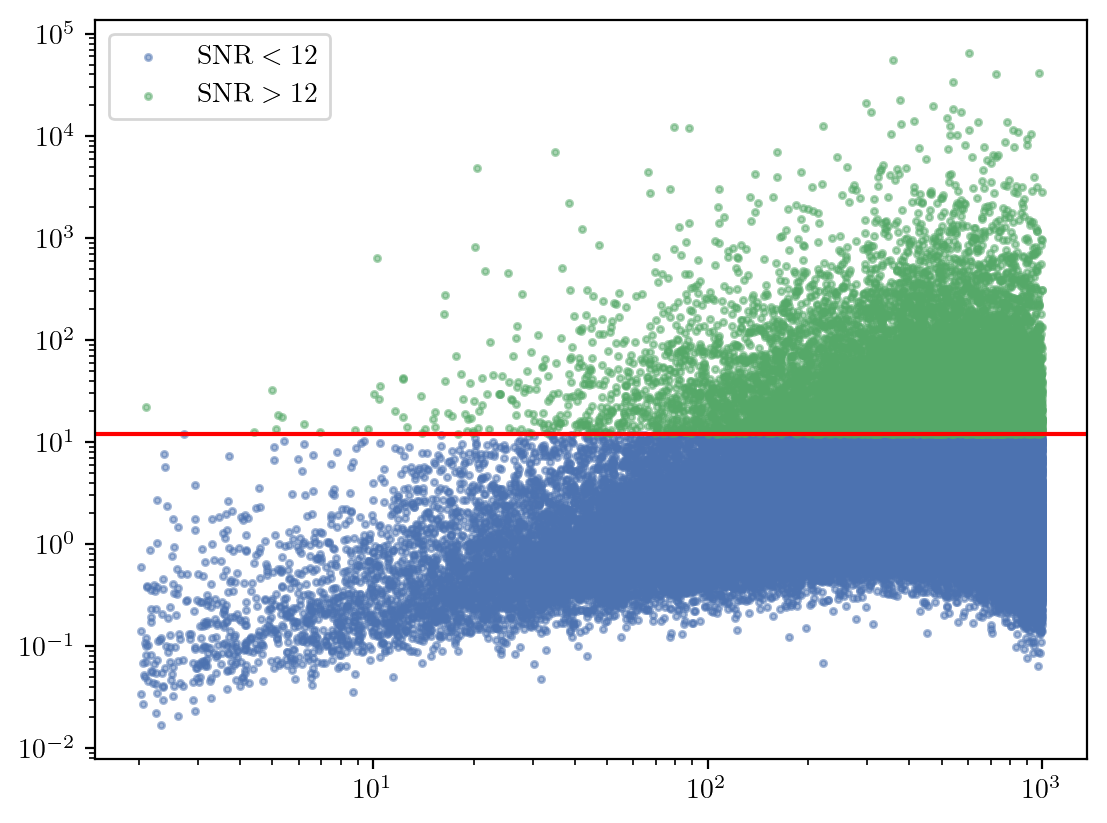

In [6]:
#plt.scatter(mtot, snr, s=5, alpha=0.5)
plt.scatter(mtot[det==0], snr[det==0], s=5, alpha=0.5, c='C0', edgecolors='C0', label=r"$\mathrm{SNR} < 12$")
plt.scatter(mtot[det==1], snr[det==1], s=5, alpha=0.5, c='C1', edgecolors='C1', label=r"$\mathrm{SNR} > 12$")
plt.axhline(12, color = 'red')
plt.loglog()
plt.legend()
plt.show()

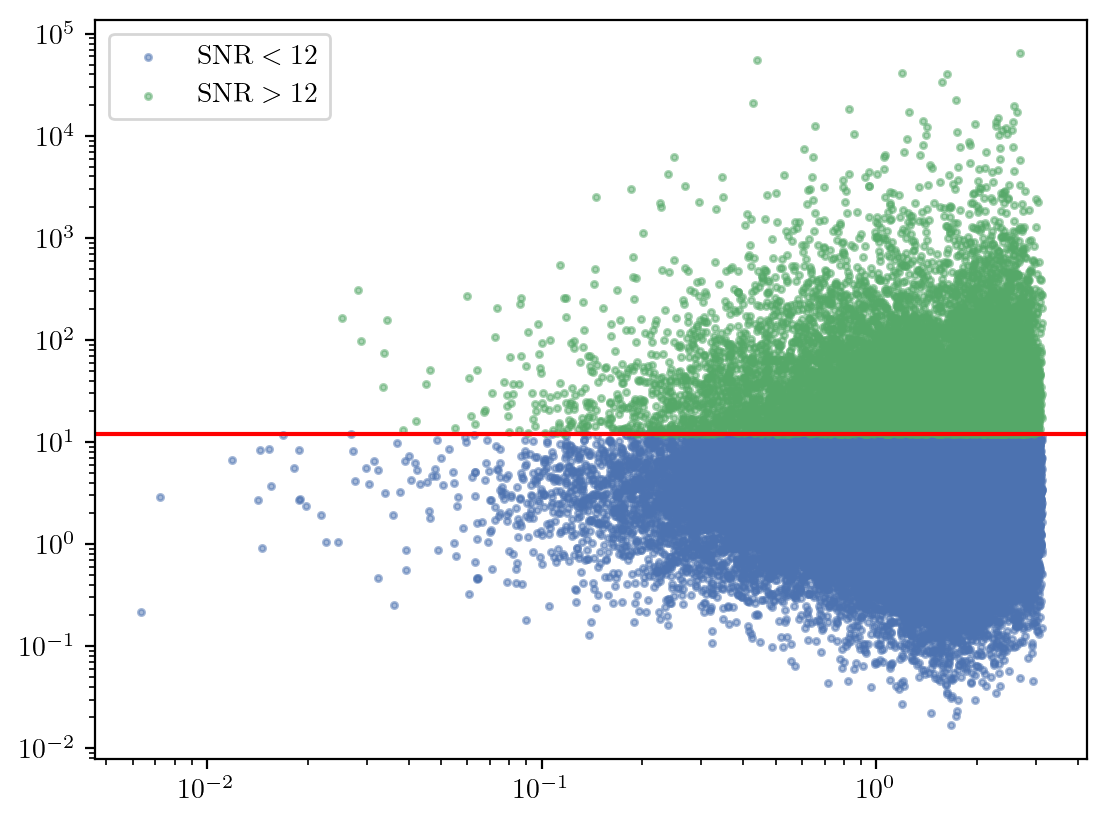

In [7]:
plt.scatter(iota[det==0], snr[det==0], s=5, alpha=0.5, c='C0', edgecolors='C0', label=r"$\mathrm{SNR} < 12$")
plt.scatter(iota[det==1], snr[det==1], s=5, alpha=0.5, c='C1', edgecolors='C1', label=r"$\mathrm{SNR} > 12$")
plt.axhline(12, color = 'red')
plt.loglog()
plt.legend()
plt.show()

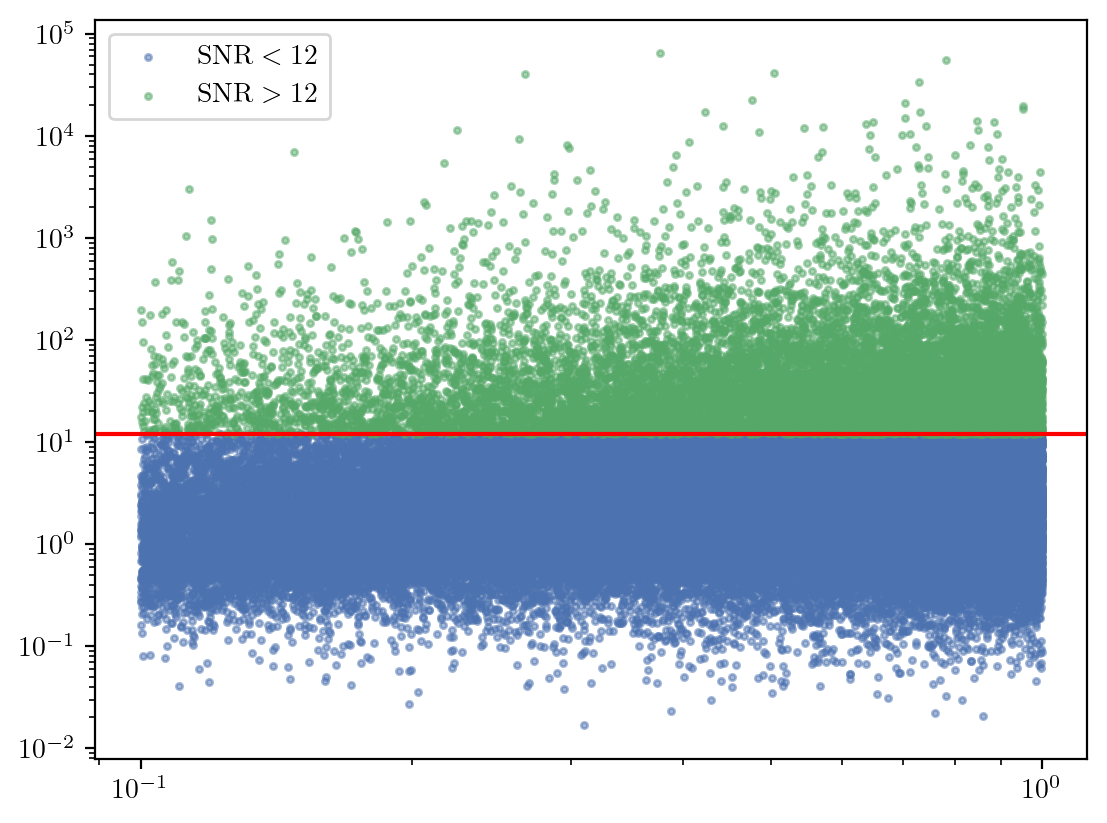

In [8]:
plt.scatter(q[det==0], snr[det==0], s=5, alpha=0.5, c='C0', edgecolors='C0', label=r"$\mathrm{SNR} < 12$")
plt.scatter(q[det==1], snr[det==1], s=5, alpha=0.5, c='C1', edgecolors='C1', label=r"$\mathrm{SNR} > 12$")
plt.axhline(12, color = 'red')
plt.loglog()
plt.legend()
plt.show()

# Classification

In [9]:
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(X, y, snr, test_size=0.3, random_state=42)

## DecisionTree

In [10]:
clf = DecisionTreeClassifier(random_state=0, max_depth=5, criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)

In [11]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

In [12]:
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(C)

Confusion matrix:
[[25286   392]
 [ 1305  3017]]


In [13]:
accuracy_dt = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_dt)

Accuracy: 0.9434333333333333


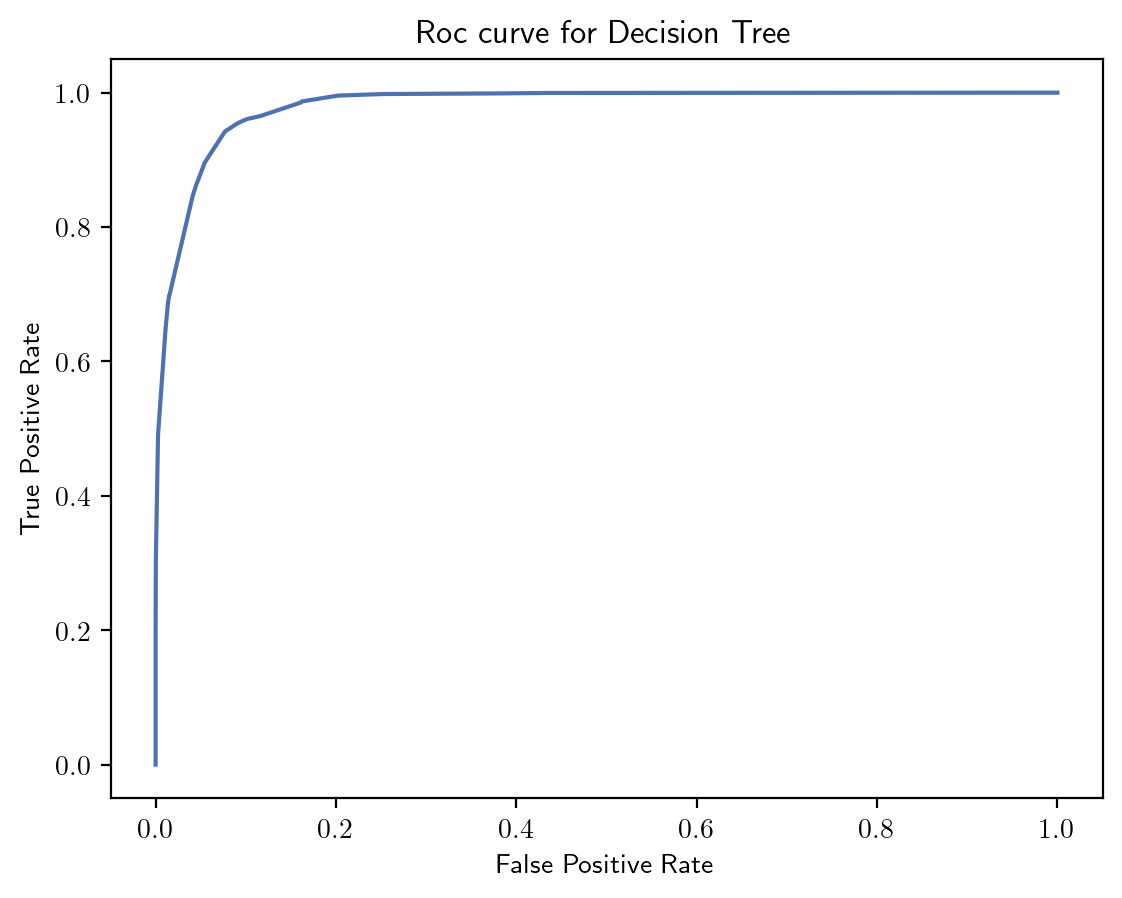

In [14]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test,y_prob)

plt.plot(fpr_dt, tpr_dt)
plt.title('Roc curve for Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [15]:
comp_dt, cont_dt = completeness_contamination(y_pred, y_test)
print('Completeness test:', comp_dt)
print('Contamination test:', cont_dt)

Completeness test: 0.6980564553447478
Contamination test: 0.11498973305954825


#### Tune Decision Tree parameter max_depth

In [16]:
max_depth_grid = {'max_depth': np.linspace(5, 25, 20, dtype=int)}

grid_search = GridSearchCV(clf, max_depth_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best accuracy:", grid_search.best_score_)

Best max_depth: 10
Best accuracy: 0.9567285714285714


The accuracy increases slightly, but maybe at the cost of overfitting. Let's check.

#### Check for overfitting

In [17]:
completeness_test = []
contamination_test = []
completeness_train = []
contamination_train = []

md_grid = np.arange(1,20)

for max_depth in tqdm(md_grid):
    clf = DecisionTreeClassifier(random_state=0, max_depth=max_depth, criterion='entropy')
    clf.fit(X_train, y_train)

    y_pred_test = clf.predict(X_test)
    comp_test, cont_test = completeness_contamination(y_pred_test, y_test)
    completeness_test.append(comp_test)
    contamination_test.append(cont_test)

    y_pred_train = clf.predict(X_train)
    comp_train, cont_train = completeness_contamination(y_pred_train, y_train)
    completeness_train.append(comp_train)
    contamination_train.append(cont_train)

  0%|          | 0/19 [00:00<?, ?it/s]

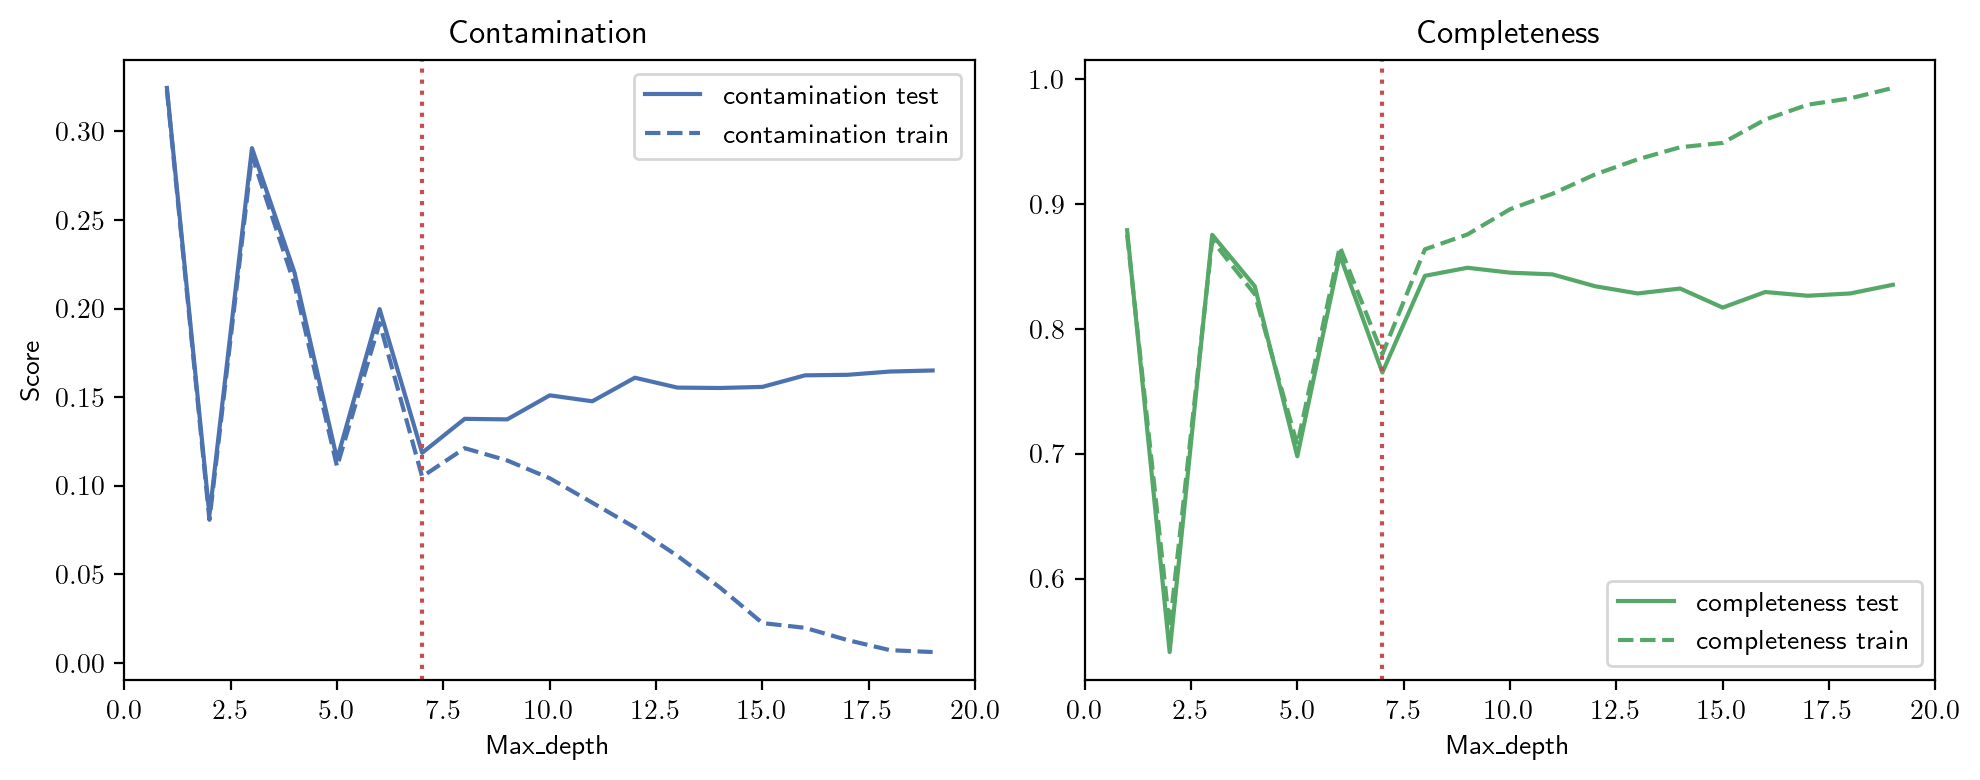

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(md_grid, contamination_test, label='contamination test', c='C0')
axes[0].plot(md_grid, contamination_train, label='contamination train', c='C0', ls='--')
axes[0].axvline(7, color='C2', linestyle='dotted')
axes[0].set_xlabel('Max_depth')
axes[0].set_ylabel('Score')
axes[0].set_xlim(0, 20)
axes[0].legend()
axes[0].set_title('Contamination')

axes[1].plot(md_grid, completeness_test, label='completeness test', c='C1')
axes[1].plot(md_grid, completeness_train, label='completeness train', c='C1', ls='--')
axes[1].axvline(7, color='C2', linestyle='dotted')
axes[1].set_xlabel('Max_depth')
axes[1].set_xlim(0, 20)
axes[1].legend()
axes[1].set_title('Completeness')

# Migliora la disposizione
plt.tight_layout()
plt.show()


The overfitting starts at a max_depth of around 7.

In [19]:
clf = DecisionTreeClassifier(random_state=0, max_depth=7, criterion='entropy')
clf.fit(X_train, y_train)

C = sklearn.metrics.confusion_matrix(y_test, y_pred)
print('Decision matrix:')
print(C)

accuracy_dt = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_dt)

Decision matrix:
[[25286   392]
 [ 1305  3017]]
Accuracy: 0.9434333333333333


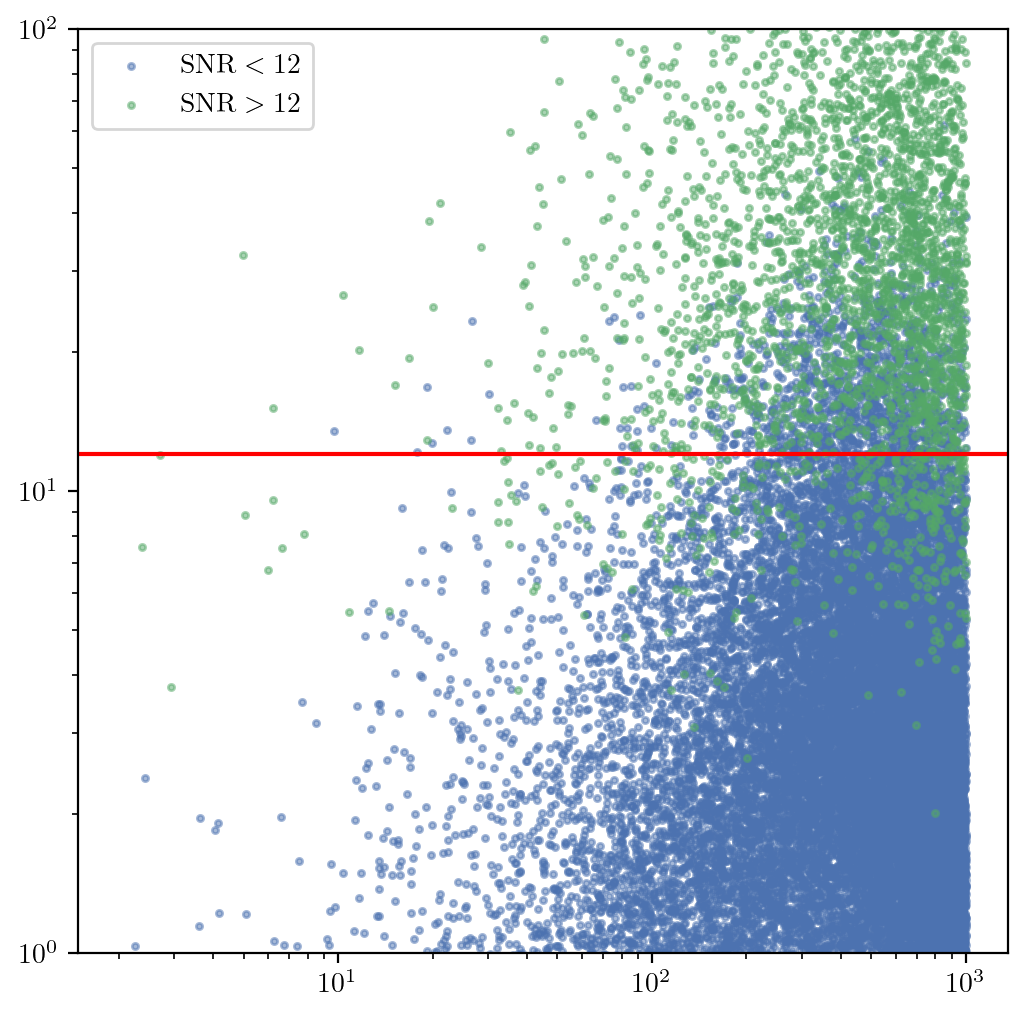

In [20]:
mtot_test = X_test[:,8]

plt.figure(figsize=(6,6))

plt.scatter(mtot_test[y_pred==0], snr_test[y_pred==0], s=5, alpha=0.5, c='C0', edgecolors='C0', label=r"$\mathrm{SNR} < 12$")
plt.scatter(mtot_test[y_pred==1], snr_test[y_pred==1], s=5, alpha=0.5, c='C1', edgecolors='C1', label=r"$\mathrm{SNR} > 12$")
plt.axhline(12, color = 'red')

plt.ylim(1,100)
plt.loglog()
plt.legend()
plt.show()

## RandomForest

In [21]:
ranfor = RandomForestClassifier(n_estimators=150, max_depth=7, criterion='entropy',n_jobs=-1, random_state=0)
ranfor.fit(X,y)

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=150,
                       n_jobs=-1, random_state=0)

In [22]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

In [23]:
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
print('Decision matrix:')
print(C)

Decision matrix:
[[25233   445]
 [ 1015  3307]]


In [24]:
accuracy_rf = accuracy_score(y_test, y_pred)
print(accuracy_dt)

0.9434333333333333


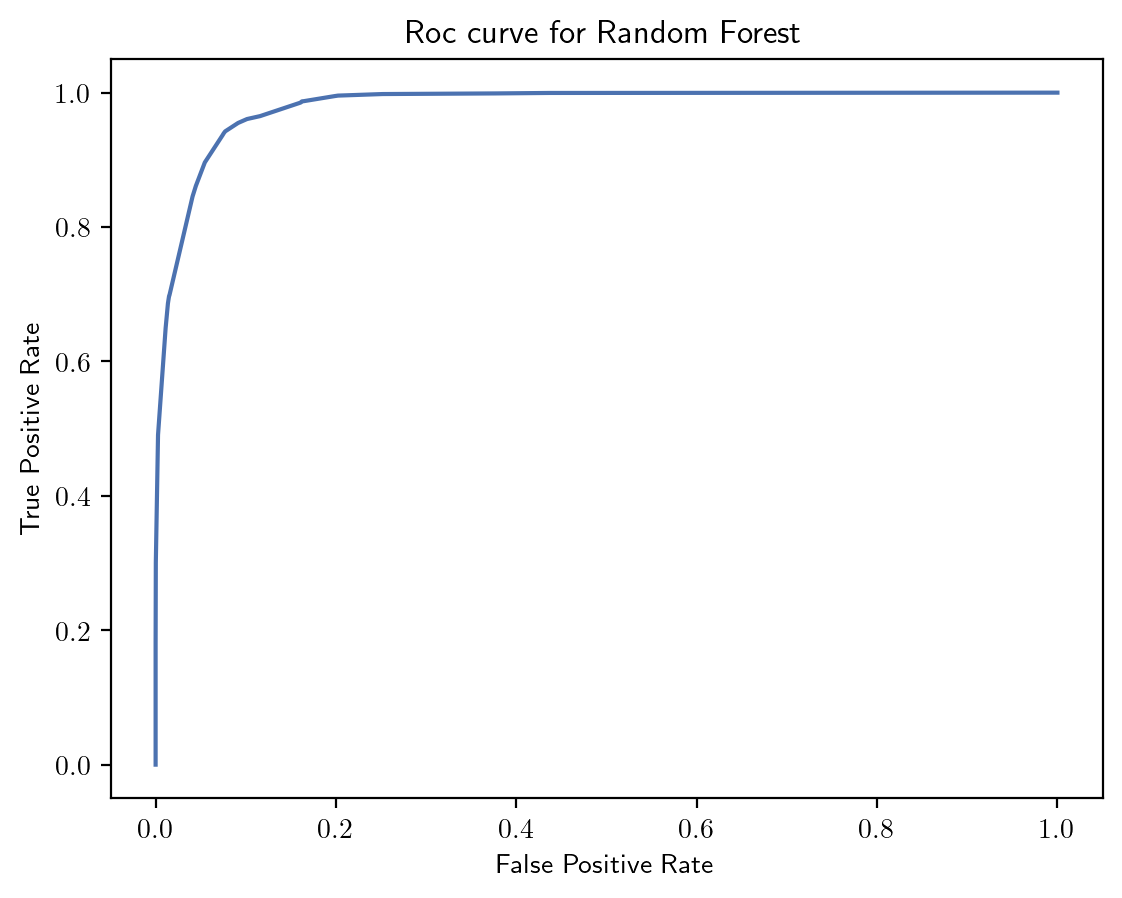

In [25]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test,y_prob)

plt.plot(fpr_dt, tpr_dt)
plt.title('Roc curve for Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [26]:
comp_rf, cont_rf = completeness_contamination(y_pred, y_test)
print('Completeness test:', comp_rf)
print('Contamination test:', cont_rf)

Completeness test: 0.7651550208236927
Contamination test: 0.11860341151385928


#### Check for overfitting

Max depth

In [27]:
completeness_test = []
contamination_test = []
completeness_train = []
contamination_train = []

md_grid = np.arange(1,20,2)

for md in tqdm(md_grid):
    ranfor = RandomForestClassifier(n_estimators=150, max_depth=md, criterion='entropy',n_jobs=-1)
    ranfor.fit(X_train, y_train)

    y_pred_test = ranfor.predict(X_test)
    comp_test, cont_test = completeness_contamination(y_pred_test, y_test)
    completeness_test.append(comp_test)
    contamination_test.append(cont_test)
    
    y_pred_train = ranfor.predict(X_train)
    comp_train, cont_train = completeness_contamination(y_pred_train, y_train)
    completeness_train.append(comp_train)
    contamination_train.append(cont_train)

  0%|          | 0/10 [00:00<?, ?it/s]

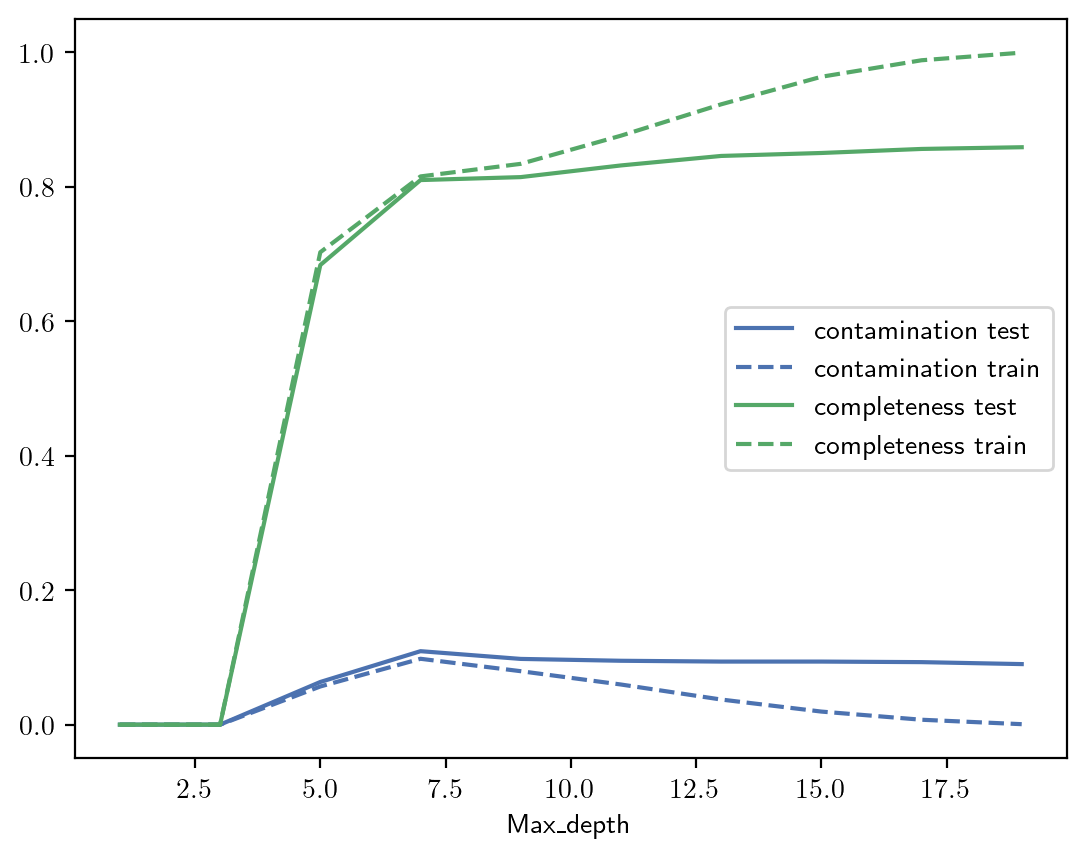

In [28]:
plt.plot(md_grid, contamination_test, label='contamination test', c='C0')
plt.plot(md_grid, contamination_train, label='contamination train', c='C0', ls='--')

plt.plot(md_grid, completeness_test, label='completeness test', c='C1')
plt.plot(md_grid, completeness_train, label='completeness train', c='C1', ls='--')

plt.xlabel('Max_depth')
#plt.xlim(0,20)
#plt.ylim(0,1)
plt.legend()
plt.show()

In this case too, the overfitting starts around max_depth=7.

In [29]:
completeness_test = []
contamination_test = []
completeness_train = []
contamination_train = []

n_est_grid = np.arange(50, 401, 50)

for n_est in tqdm(n_est_grid):
    ranfor = RandomForestClassifier(n_estimators=n_est, max_depth=7, criterion='entropy',n_jobs=-1)
    ranfor.fit(X_train, y_train)

    y_pred_test = ranfor.predict(X_test)
    comp_test, cont_test = completeness_contamination(y_pred_test, y_test)
    completeness_test.append(comp_test)
    contamination_test.append(cont_test)
    
    y_pred_train = ranfor.predict(X_train)
    comp_train, cont_train = completeness_contamination(y_pred_train, y_train)
    completeness_train.append(comp_train)
    contamination_train.append(cont_train)

  0%|          | 0/8 [00:00<?, ?it/s]

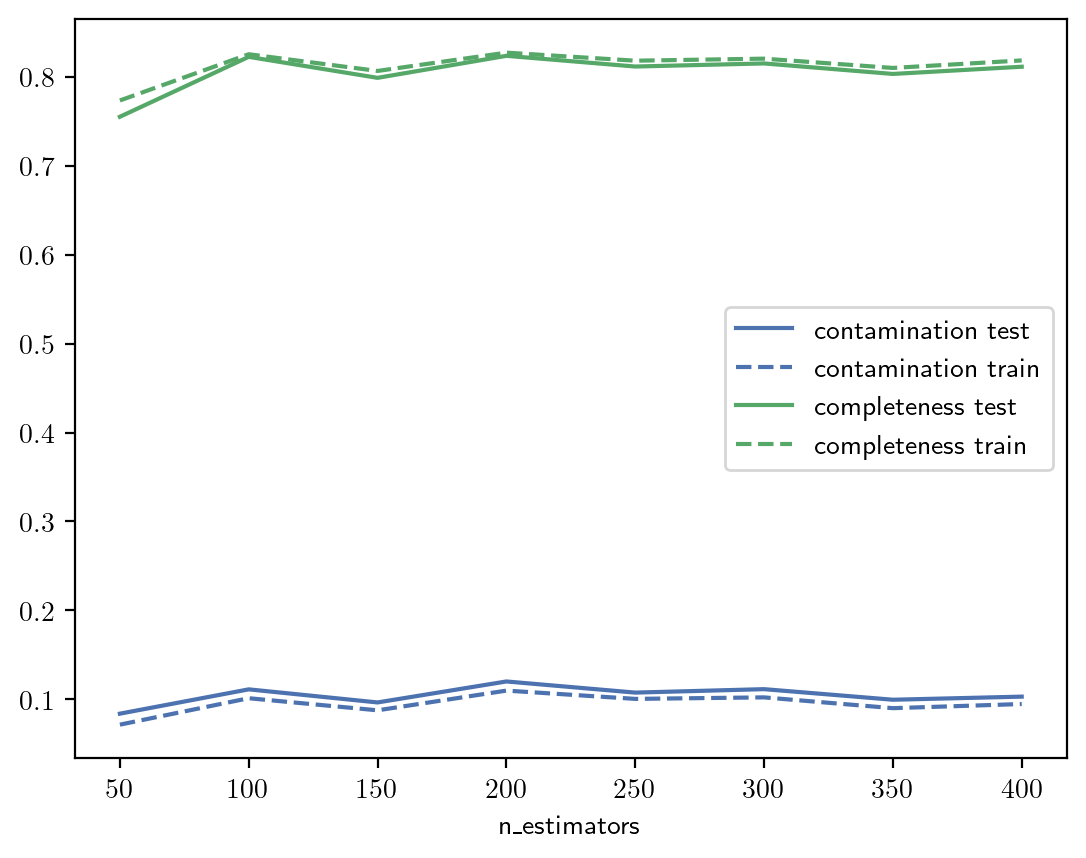

In [30]:
plt.plot(n_est_grid, contamination_test, label='contamination test', c='C0')
plt.plot(n_est_grid, contamination_train, label='contamination train', c='C0', ls='--')

plt.plot(n_est_grid, completeness_test, label='completeness test', c='C1')
plt.plot(n_est_grid, completeness_train, label='completeness train', c='C1', ls='--')

plt.xlabel('n_estimators')
#plt.xlim(0,20)
#plt.ylim(0,1)
plt.legend()
plt.show()

## Gradient Boosting

In [31]:
gbc = GradientBoostingClassifier(n_estimators=150, max_depth=7, random_state=0)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=7, n_estimators=150, random_state=0)

In [32]:
y_pred = gbc.predict(X_test)
y_prob = gbc.predict_proba(X_test)[:,1]

In [33]:
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
print('Decision matrix:')
print(C)

Decision matrix:
[[25359   319]
 [  459  3863]]


In [34]:
accuracy_gb = accuracy_score(y_test, y_pred)
print(accuracy_gb)

0.9740666666666666


The accuracy is higher than before!

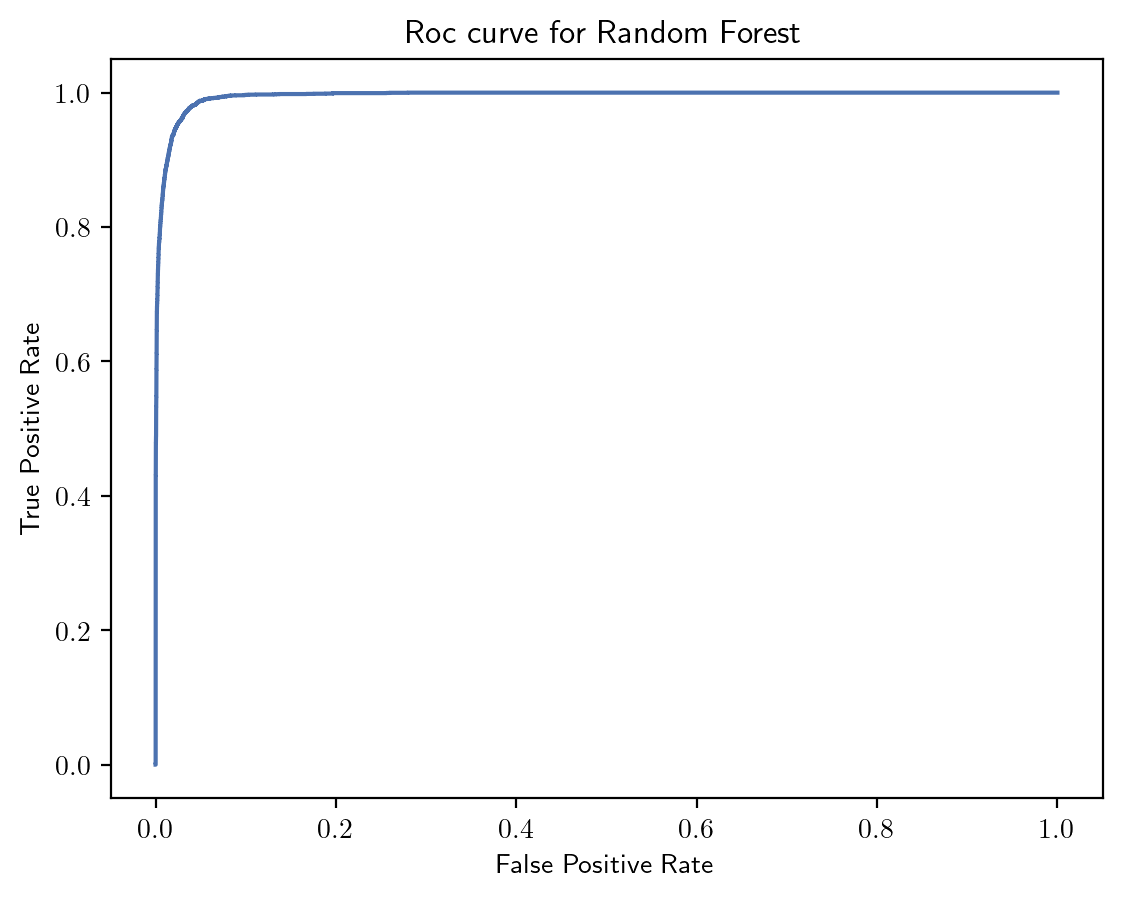

In [35]:
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test,y_prob)

plt.plot(fpr_gb, tpr_gb)
plt.title('Roc curve for Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

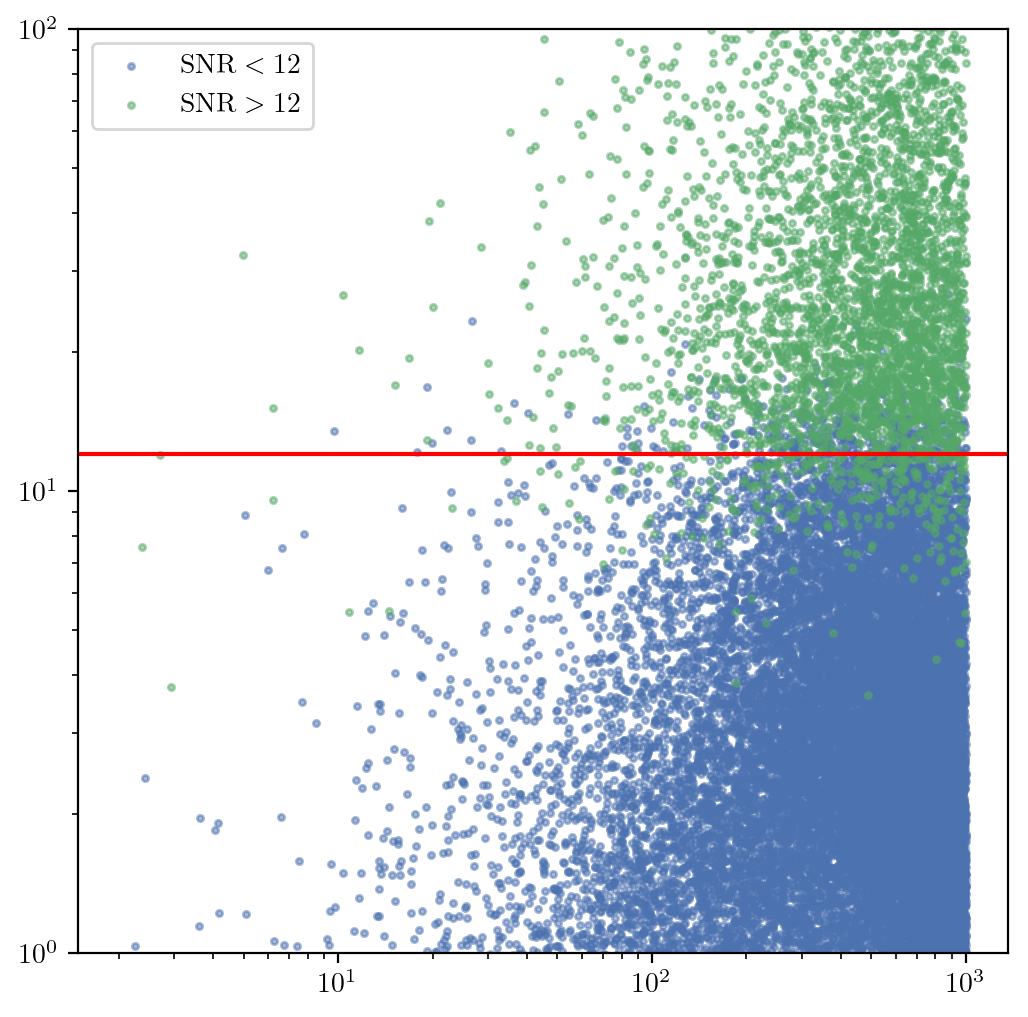

In [36]:
mtot_test = X_test[:,8]

plt.figure(figsize=(6,6))

plt.scatter(mtot_test[y_pred==0], snr_test[y_pred==0], s=5, alpha=0.5, c='C0', edgecolors='C0', label=r"$\mathrm{SNR} < 12$")
plt.scatter(mtot_test[y_pred==1], snr_test[y_pred==1], s=5, alpha=0.5, c='C1', edgecolors='C1', label=r"$\mathrm{SNR} > 12$")
plt.axhline(12, color = 'red')

plt.ylim(1,100)
plt.loglog()
plt.legend()
plt.show()

## Compare the accuracies for the different classifiers

In [37]:
print('Accuracy for DecisionTree classifier:', accuracy_dt)
print('Accuracy for RandomForest classifier:', accuracy_rf)
print('Accuracy for GradientBoosting classifier:', accuracy_gb)

Accuracy for DecisionTree classifier: 0.9434333333333333
Accuracy for RandomForest classifier: 0.9513333333333334
Accuracy for GradientBoosting classifier: 0.9740666666666666


## PCA

Explained variance ratio: [0.07852732 0.07797338 0.07757805 0.07726913 0.077183   0.07708024
 0.076812   0.07658566 0.07644656 0.07633539 0.07627534 0.07612175
 0.07581218]
Sum of explained variance: 1.0000000000000002


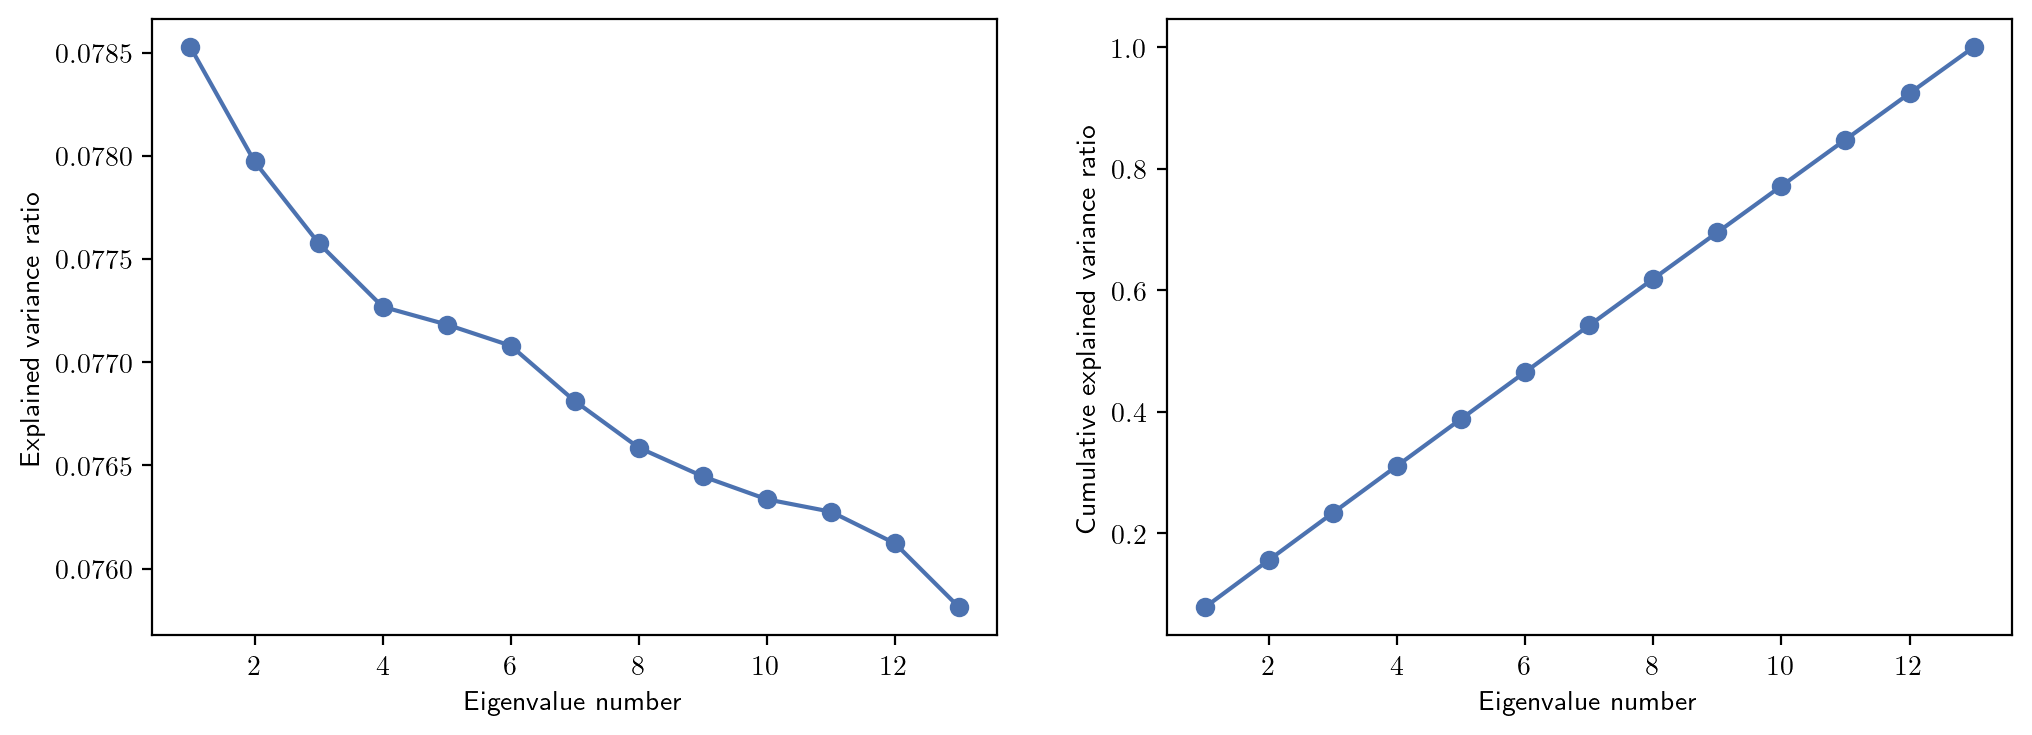

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=13)
pca.fit(X_scaled)

eigenvalues = pca.transform(X_scaled)
mean = pca.mean_
eigenvectors = pca.components_
evals = pca.explained_variance_ratio_

print("Explained variance ratio:", evals)
print("Sum of explained variance:", np.sum(evals))

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
n_components = np.arange(1, len(pca.explained_variance_ratio_) + 1)

ax[0].plot(n_components, evals, marker='o')
ax[0].set_xlabel("Eigenvalue number")
ax[0].set_ylabel("Explained variance ratio")

ax[1].plot(n_components, np.cumsum(evals), marker='o')
ax[1].set_xlabel("Eigenvalue number")
ax[1].set_ylabel("Cumulative explained variance ratio")

plt.show()

There doesn't seem to be a preferred direction for the variance. So PCA doesn't seem to be very useful for improving this classification.